[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/broad-1/quickstarters/basic-eda/basic-EDA.ipynb)

# Broad Institute: Autoimmune Disease Machine Learning Challenge

![Cover](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/broad-1/cover.jpg)

## Crunch 1 – Quickstarter

## The Problem

Autoimmune diseases arise when the immune system mistakenly targets healthy cells. Affecting 50M people in the U.S., with rising global cases, Inflammatory Bowel Disease (IBD) is one of the most prevalent forms. IBD involves a breakdown in the gut barrier, triggering the immune system to attack proteins erroneously recognized as foreign, leading to persistent inflammation. This cycle of flares and remission increases the risk of colorectal cancer (up to two-fold). Although modern treatments have improved survival, IBD remains challenging to diagnose and treat due to its complex symptoms and multifactorial nature.
Pathologists rely on gut tissue images to diagnose and treat IBD, guiding decisions on the most suitable drug treatments and predicting cancer risk. These tissue images, combined with recent advances in genomics, offer a valuable dataset for machine learning models to revolutionize IBD diagnosis and treatment.

## The Solution

In Crunch 1, you will train an algorithm to predict spatial transcriptomics data (gene expression in each cell). In other words predict the gene expression (Y) in cells from specific tissue patches based on the H&E images (X) and surrounding spatial transcriptomics data.

#### X (Input):

- **HE_registered**: The registered H&E image, aligned to the Xenium spatial transcriptomics coordinate system. This is the recommended file to use as it is already aligned with the spatial transcriptomics data.

- **HE_original**: The original H&E image in its native pixel coordinates, before alignment. If you prefer to handle alignment yourself, you can use this, but it may require additional processing.

#### Y (Output):

- **anucleus**: This file contains the aggregated gene expression data for each nucleus. It is log1p-normalized and stores the gene expression profiles for 460 genes per nucleus. This is the primary target (Y) for your model.

- **transcripts**: This file contains the spatial locations and individual gene expression data for each transcript in the tissue, linked to specific nuclei. It provides the raw gene expression information before aggregation.

# Preliminary Setup Step

In [ ]:
%pip install --upgrade crunch-cli

In [ ]:
# Registering to this Crunch

# Step 1:
# Create an account here: https://hub.crunchdao.com/auth/register

# Step 2:
# Get your set token here: https://hub.crunchdao.com/competitions/broad-1/submit/via/notebook
!crunch setup --notebook broad hello --token aaaabbbbccccddddeeeeffff

# Data Preparation

## Imports

In [1]:
"""
This is a basic example of what you need to do to enter the competition.
The code will not have access to the internet (or any socket related operation).
"""
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
import spatialdata_plot
import spatialdata as sd
import scanpy as sc

In [113]:
def square(i):
    
    return int(i)*int(i)
names=['1','2']
dict={i: square(i) for i in names}
dict['2']


4

In [28]:
from PIL import Image 
import torchvision.transforms as transforms
import torch
trans=transforms.Compose([transforms.ColorJitter(0.5, 0.5, 0.5), transforms.ToTensor()])
img= torch.Tensor(np.array(Image.open('E:/projects/Gene_expression/data/her2st/data/ST-imgs/A/A1/9769_C1_HE_small.jpg')))
print(img.size(),img.permute(1, 0, 2).size())
img= trans( img
)
print(img.size(),img.permute(1, 0, 2).size())
del img


torch.Size([7435, 6954, 3]) torch.Size([6954, 7435, 3])


TypeError: Input image tensor permitted channel values are [1, 3], but found 7435

## The datasets

In [3]:
# del sdata

sdata = sd.read_zarr(f"../data/DC5.zarr")
sdata

E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: C:\DATA\Crunch\data\DC5.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 18000, 22000)
│     └── 'HE_original': DataArray[cyx] (3, 18000, 22000)
└── Tables
      ├── 'anucleus': AnnData (140368, 460)
      └── 'cell_id-group': AnnData (171019, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

In [34]:
train=sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']['cell_id'].values
train.sort()


In [35]:
train

array([     6,     12,     14, ..., 224297, 224301, 224325], dtype=uint32)

In [10]:
from skimage.measure import regionprops

regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

train_length= len( sdata['anucleus'].layers['counts'])



NameError: name 'random' is not defined

In [ ]:
partial_train_length=int(train_length*0.9)
split_train_binary=[1] * partial_train_length + [0] * (train_length-partial_train_length)
# split_train_binary=[1] * 62000 + [0] * (train_length-62000)
random.shuffle(split_train_binary)
print(len(split_train_binary),train_length,int(train_length*0.9))

center_list=[]
cell_id_list=[]
# Getting back the objects:
# with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#     obj0, obj1, obj2 = pickle.load(f)
i=0
for props in tqdm(regions):
    cell_id= props.label
    
    if i!=cell_id:
        print(i,cell_id)
    i+=1
    if cell_id >= len( sdata['anucleus'].layers['counts']):
        continue
    
    if split_train_binary[cell_id] ==0:
        continue
    
    
    centroid = props.centroid
    center_list.append([int(centroid[0]), int(centroid[1])])
    cell_id_list.append(int(cell_id))
print(len(center_list))

In [12]:
sdata['HE_original'].to_numpy().shape

(3, 20000, 21000)

In [20]:
trans(Image.fromarray(np.transpose(sdata['HE_original'].to_numpy(),(2,1,0)))).size()

torch.Size([3, 21000, 20000])

In [ ]:
np.array(trans(Image.fromarray(np.transpose(sdata['HE_original'].to_numpy()[:,1500:1550,1500:1560],(2,1,0))))).shape

(60, 50, 3)

In [19]:
trans(Image.fromarray(np.transpose(sdata['HE_original'].to_numpy()[:,1500:1550,1500:1560],(2,1,0)))).size()

torch.Size([3, 60, 50])

In [30]:
np.array(trans(Image.fromarray(np.transpose(sdata['HE_original'].to_numpy()[:,1500:1550,1500:1560],(2,1,0))))).shape

(3, 60, 50)

## Input (X) - H&E Images

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


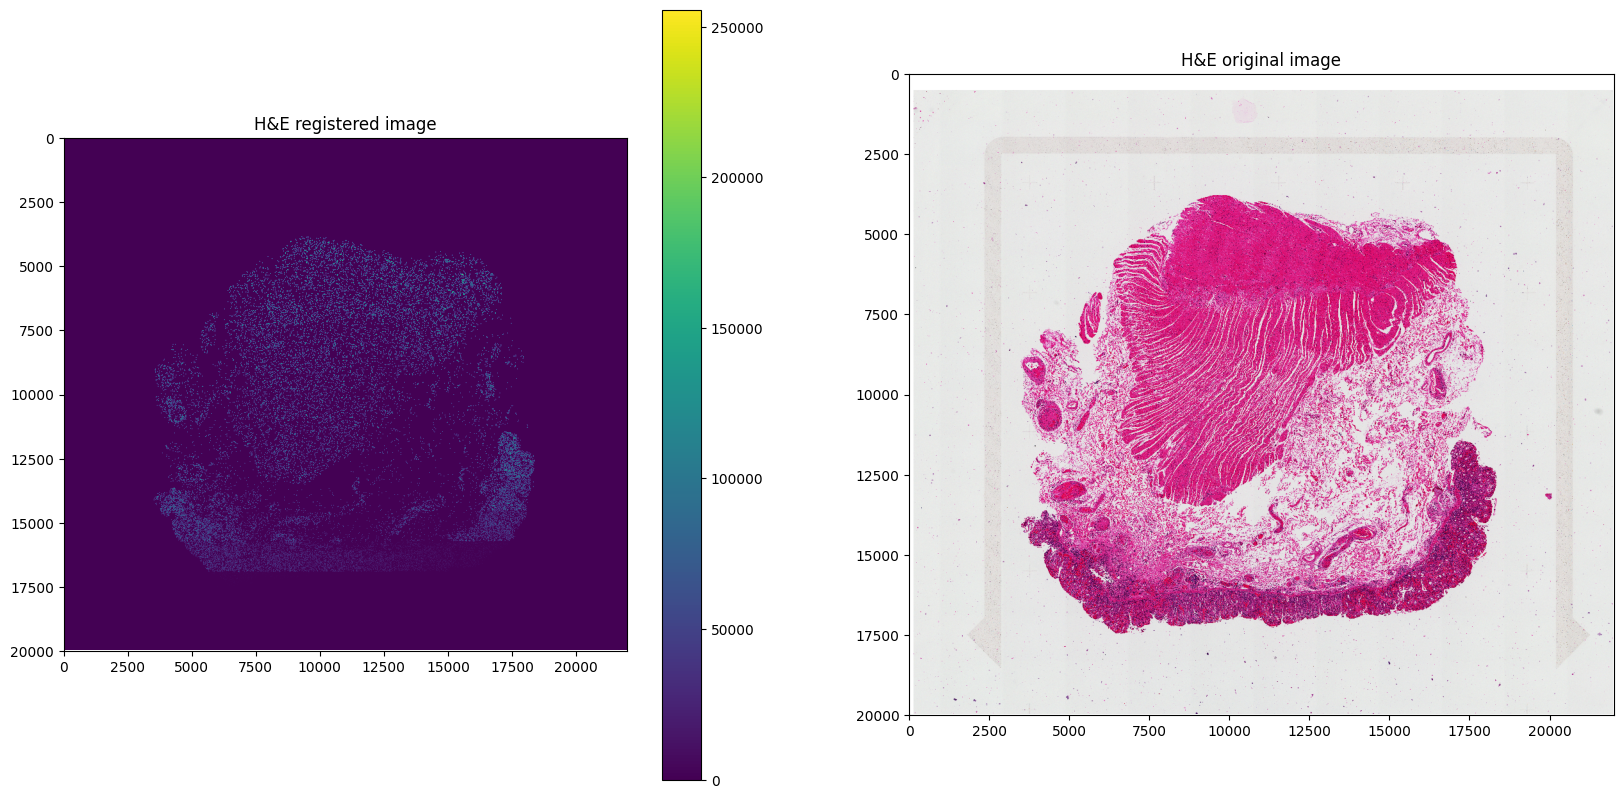

In [13]:
##  H&E pathology image
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the axes to easily index them

sdata.pl.render_images("HE_nuc_original").pl.show(ax=axes[0], title="H&E registered image", coordinate_systems="global")
sdata.pl.render_images("HE_original").pl.show(ax=axes[1], title="H&E original image", coordinate_systems="global")

## Target (Y) -  aggregated gene expression data for each cell

In [4]:
## Get the list of gene concerned in crunch 1
gene_name_list = sdata['anucleus'].var['gene_symbols'].values
print(gene_name_list, len( gene_name_list))

['A2M' 'ACP5' 'ACTA2' 'ADAMTSL3' 'AFAP1L2' 'AHR' 'ALDH1B1' 'ANO1' 'ANXA1'
 'AQP1' 'AQP8' 'AREG' 'ASCL2' 'ATIC' 'AVIL' 'AXL' 'BANK1' 'BATF' 'BCAS1'
 'BMX' 'BNC2' 'BTNL9' 'C1QA' 'C1QC' 'C3' 'C7' 'CA1' 'CA2' 'CA4' 'CA7'
 'CADM1' 'CADPS' 'CALCB' 'CARD9' 'CAV1' 'CBLB' 'CCK' 'CCL1' 'CCL11'
 'CCL13' 'CCL19' 'CCL2' 'CCL20' 'CCL22' 'CCL23' 'CCL24' 'CCL3L1' 'CCL4'
 'CCL5' 'CCL7' 'CCL8' 'CCNB1' 'CCR1' 'CCR2' 'CCR3' 'CCR4' 'CCR5' 'CCR6'
 'CCR7' 'CCR8' 'CD163' 'CD163L1' 'CD19' 'CD1C' 'CD2' 'CD209' 'CD22'
 'CD247' 'CD27' 'CD300E' 'CD36' 'CD38' 'CD3D' 'CD3G' 'CD4' 'CD40LG' 'CD5'
 'CD55' 'CD6' 'CD68' 'CD69' 'CD7' 'CD79A' 'CD83' 'CD86' 'CD8A' 'CD8B'
 'CD9' 'CDC20' 'CDCA7' 'CDHR5' 'CDK1' 'CDK15' 'CDKN2B' 'CEACAM1' 'CEACAM7'
 'CELF2' 'CES1' 'CES2' 'CFTR' 'CHAT' 'CHGB' 'CHI3L1' 'CLC' 'CLCA4'
 'CLEC10A' 'CLEC9A' 'CMTM2' 'CNRIP1' 'COL14A1' 'COL4A2' 'COL6A3' 'CORO1A'
 'COX4I2' 'CRTAM' 'CSF1R' 'CSF3' 'CST7' 'CSTA' 'CTLA4' 'CXCL1' 'CXCL10'
 'CXCL11' 'CXCL12' 'CXCL13' 'CXCL2' 'CXCL3' 'CXCL5' 'CXCL6' 'CXCR1'
 'C

In [ ]:
# !pip install napari-spatialdata
# !pip install pyqt5


In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
from spatialdata import SpatialData

from napari_spatialdata import Interactive

In [6]:
sdata['anucleus']

AnnData object with n_obs × n_vars = 140368 × 460
    obs: 'cell_id'
    var: 'gene_symbols'
    obsm: 'spatial'
    layers: 'counts'

In [7]:
x_count = pd.DataFrame(sdata['anucleus'].layers['counts'], columns=gene_name_list) # raw count data
display(x_count)

,A2M,ACP5,ACTA2,ADAMTSL3,AFAP1L2,AHR,ALDH1B1,ANO1,ANXA1,AQP1,...,VCAN,VIL1,VIM,VPREB3,VWA5A,WFDC2,XBP1,XCL2,XCR1,ZEB2
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140363,2,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,1,0,0,0
140364,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,1,0,0,0
140365,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140366,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
x_norm = pd.DataFrame((sdata['anucleus'].X), columns=gene_name_list) # normalized data
display(x_norm)

,A2M,ACP5,ACTA2,ADAMTSL3,AFAP1L2,AHR,ALDH1B1,ANO1,ANXA1,AQP1,...,VCAN,VIL1,VIM,VPREB3,VWA5A,WFDC2,XBP1,XCL2,XCR1,ZEB2
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.233592,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.000000,2.233592,0.000000,0.0,0.0,0.0,2.233592,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,2.368131,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.0,1.185624,1.185624,0.000000,0.0,0.0,0.0,0.000000,1.185624,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140363,1.578185,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,1.072637,0.000000,1.578185,0.0,0.0,0.0,1.072637,0.0,0.0,0.0
140364,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,1.085454,0.000000,0.0,0.0,0.0,0.683295,0.0,0.0,0.0
140365,0.000000,0.0,0.960462,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
140366,0.000000,0.0,0.000000,0.000000,0.832344,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [41]:
## Selecting training cells
cell_id_example = sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']['cell_id'].to_numpy()
cell_id_example = list(set(cell_id_example).intersection(set(sdata['anucleus'].obs['cell_id'].unique())))

## Get y from the anucleus data
ground_truth_example = sdata['anucleus'].layers['counts'][sdata['anucleus'].obs['cell_id'].isin(cell_id_example),:]

In [22]:
# sdata['cell_id-group'].obs['cell_id']
sdata['cell_id-group'].obs['group'].unique()
sdata['cell_id-group']
sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']


,cell_id,group
5,6,train
11,12,train
13,14,train
22,23,train
36,37,train
...,...,...
183906,224288,train
183910,224292,train
183915,224297,train
183919,224301,train


In [17]:
# len(set(sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'test']['cell_id'].to_numpy()))
sdata,sdata['anucleus']

(SpatialData object, with associated Zarr store: C:\DATA\Crunch\data\UC1_I.zarr
 ├── Images
 │     ├── 'HE_nuc_original': DataArray[cyx] (1, 20000, 22000)
 │     └── 'HE_original': DataArray[cyx] (3, 20000, 22000)
 └── Tables
       ├── 'anucleus': AnnData (202534, 460)
       └── 'cell_id-group': AnnData (234356, 0)
 with coordinate systems:
     ▸ 'global', with elements:
         HE_nuc_original (Images), HE_original (Images),
 AnnData object with n_obs × n_vars = 202534 × 460
     obs: 'cell_id'
     var: 'gene_symbols'
     obsm: 'spatial'
     layers: 'counts')

In [42]:
y = pd.DataFrame(ground_truth_example, columns= gene_name_list, index = cell_id_example)
y

,A2M,ACP5,ACTA2,ADAMTSL3,AFAP1L2,AHR,ALDH1B1,ANO1,ANXA1,AQP1,...,VCAN,VIL1,VIM,VPREB3,VWA5A,WFDC2,XBP1,XCL2,XCR1,ZEB2
6,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224288,2,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,1,0,0,0
224292,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,1,0,0,0
224297,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224301,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# ground_truth_example
set(sdata['anucleus'].obs['cell_id'])
test_array=sdata['anucleus'].X
split_train_binary=np.array([1]*140000 + [0]*368)
test_array= test_array[split_train_binary==1]
test_array.shape


(140000, 460)

In [49]:

import numpy as np
import pickle
# Example 2D array (m x n)
array_1 = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12]
])
array_2 = np.array([
    [11, 12, 13],
    [14, 15,1],
    [17, 18,1],
    [10, 12, 10]
])
array_3 = np.array([
    [11  ,5,1],
    [14, 15,  2],
    [17, 18,3],
    [10, 17, 12,]
])
# test_array=[array_1,array_2,array_3]
# test_array=np.concatenate(test_array, axis=1)
# # test_array= test_array[:1] + test_array[2:]
# # Binary 1D array with m elements
# test_array

with open(f'adata_true.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
            adata_true=   pickle.load(f)
with open(f'adata_pred.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
            adata_pred=   pickle.load(f)
with open(f'true.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
            true=   pickle.load(f)
with open(f'pred.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
            pred=   pickle.load(f)
with open(f'indices.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
            indices=   pickle.load(f)

In [52]:
adata_pred.X[100000]
indices.shape,pred.shape

((126331, 200), (126331, 460))

In [54]:
indices[1,:]

array([ 59052,  40421,  72416,  26075,  79004, 113795,  41414, 126161,
        61769,  71028,  85490, 117176,  77518,  71527,  36276, 113676,
        58019,  82699,  97682,  82552,  91715,  98292, 105629,   7734,
       101089, 113037,  49488, 124858, 126084,  24546,  91792, 120996,
       123696,  42072, 111164,  72256,   9392,   6268, 124268,  72118,
        93650,   7142, 101920, 126289,   6510,  74856,  82625, 112700,
       125811,  92476, 125684, 115633,  96742,  99851,  36496,  99679,
        73373, 126237,  58041, 123712,  84395,  32685, 113480,  92994,
       111104,  80641,  71144,  70098,  97524,  86992,  72420, 104078,
       106990,  76172,  79923,   9221, 115332, 104880,  92755,  43693,
        89279, 122083,  57414,  87501, 100104,  18362,  75078, 119716,
       116710,  16295,  71714,   7488, 118737,  66368, 109268,   6151,
       120071,  95197, 103832,  70813, 122239,  82294,  82246, 117959,
        57568,  95572,  94713, 104976, 114063, 112332, 116345,  61481,
      

In [48]:
adata_true,adata_pred

(AnnData object with n_obs × n_vars = 14037 × 460,
 AnnData object with n_obs × n_vars = 126331 × 460)

In [31]:
import os
names = os.listdir("E:/Projects/gene_expression/data/Her2st/data/ST-cnts")
names.sort()
names = [i[:2] for i in names][1:4]
test=[np.load(f"./data/preprocessed_expression_matrices/her2st/{name}/preprocessed_matrix.npy") for
            name in names]
len(test)

3

In [32]:
test_f= test[:1] + test[2:]

In [36]:
len(test_f)

2

In [43]:
sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']


,cell_id,group
5,6,train
11,12,train
13,14,train
22,23,train
36,37,train
...,...,...
183906,224288,train
183910,224292,train
183915,224297,train
183919,224301,train


# Cropping img to smaller chunks

In [ ]:
import numpy as np
from skimage.measure import regionprops
from tqdm import tqdm
import tifffile
import os

def save_cropped_cells(sdata, crop_size=128, out_dir='image_crop'):
    """
    Function to save cropped cell images from the original intensity image.

    Parameters:
    sdata: SpatialData object containing the image data.
    crop_size: Size of the square crop around each cell's centroid.
    out_dir: Directory where the cropped images will be saved.
    """
    # Create output directory if it doesn't exist
    os.makedirs(out_dir, exist_ok=True)

    # Get regions from the nucleus image
    regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

    # Get the original intensity image
    intensity_image = sdata['HE_original'].to_numpy()

    # Half of the crop size to calculate boundaries
    half_crop = crop_size // 2

    crop_list = []

    # Loop through each region and extract the crop
    for props in tqdm(regions):
        cell_id = props.label
        centroid = props.centroid
        y_center, x_center = int(centroid[0]), int(centroid[1])

        # Calculate the crop boundaries
        minr, maxr = y_center - half_crop, y_center + half_crop
        minc, maxc = x_center - half_crop, x_center + half_crop

        # Ensure boundaries are within the image dimensions
        pad_top = max(0, -minr)
        minr = max(0, minr)

        pad_bottom = max(0, maxr - intensity_image.shape[1])
        maxr = min(maxr, intensity_image.shape[1])

        pad_left = max(0, -minc)
        minc = max(0, minc)

        pad_right = max(0, maxc - intensity_image.shape[2])
        maxc = min(maxc, intensity_image.shape[2])

        # Crop and pad the image if needed
        if pad_top + pad_bottom + pad_left + pad_right > 0:
            crop = np.pad(intensity_image[:, minr:maxr, minc:maxc],
                          ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right)),
                          mode='constant', constant_values=0)
        else:
            crop = intensity_image[:, minr:maxr, minc:maxc]


        crop_list.append(crop)
        # Save the crop as a TIFF file
        tifffile.imwrite(f"{out_dir}/{cell_id}.tif", crop.astype('uint8'), metadata={'axes': 'CYX'})

    return crop_list

In [12]:
crop_list = save_cropped_cells(sdata)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93686/93686 [08:32<00:00, 182.75it/s]


# Visualization of X and y

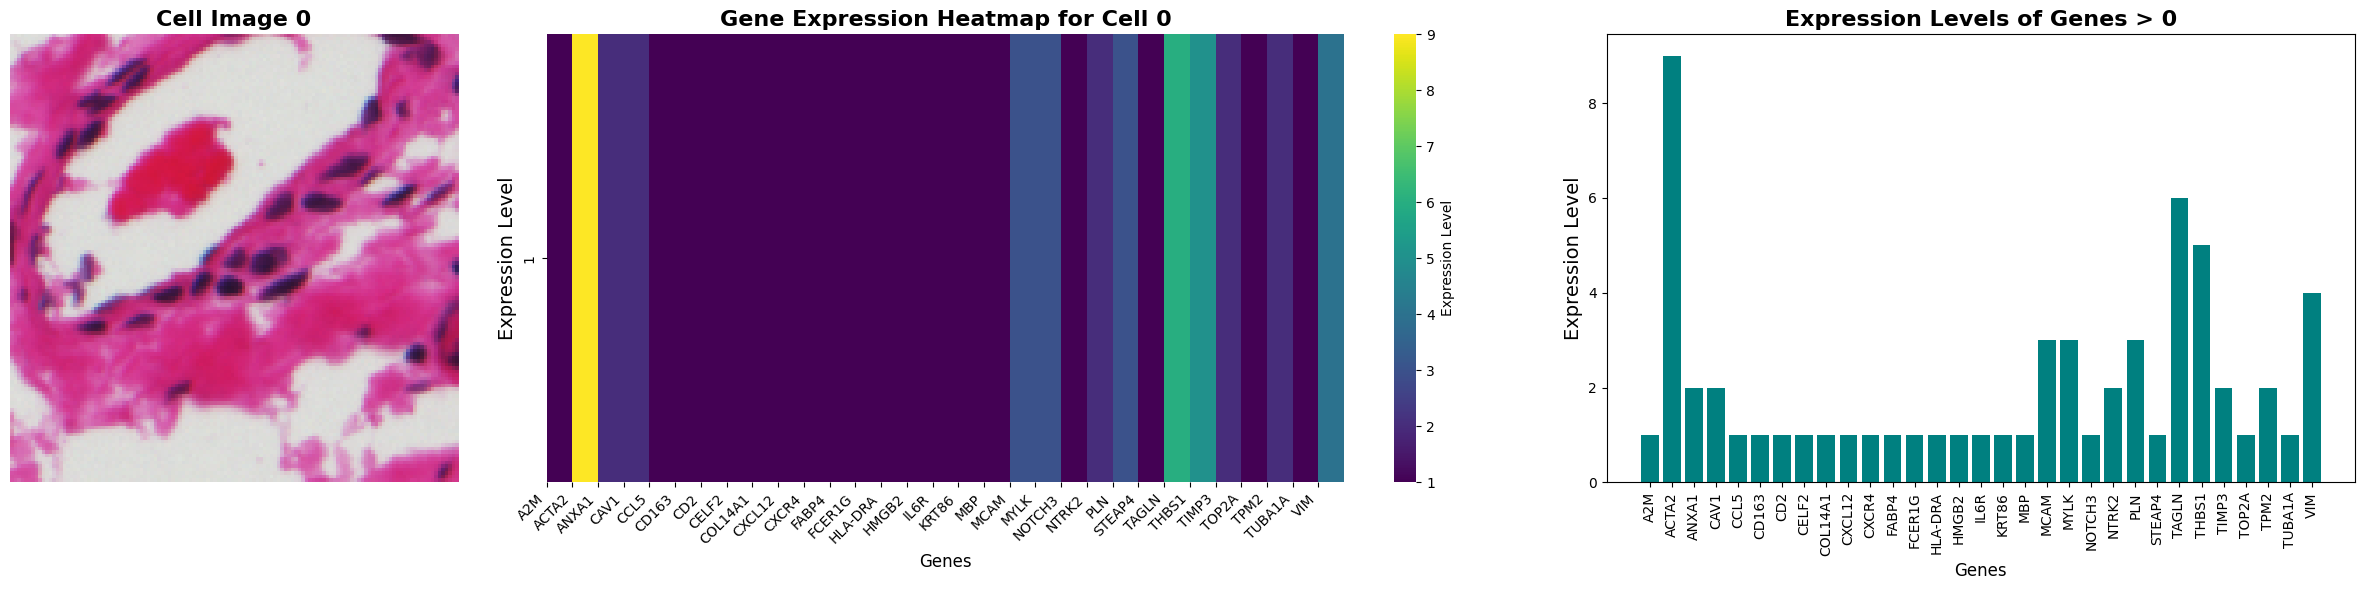

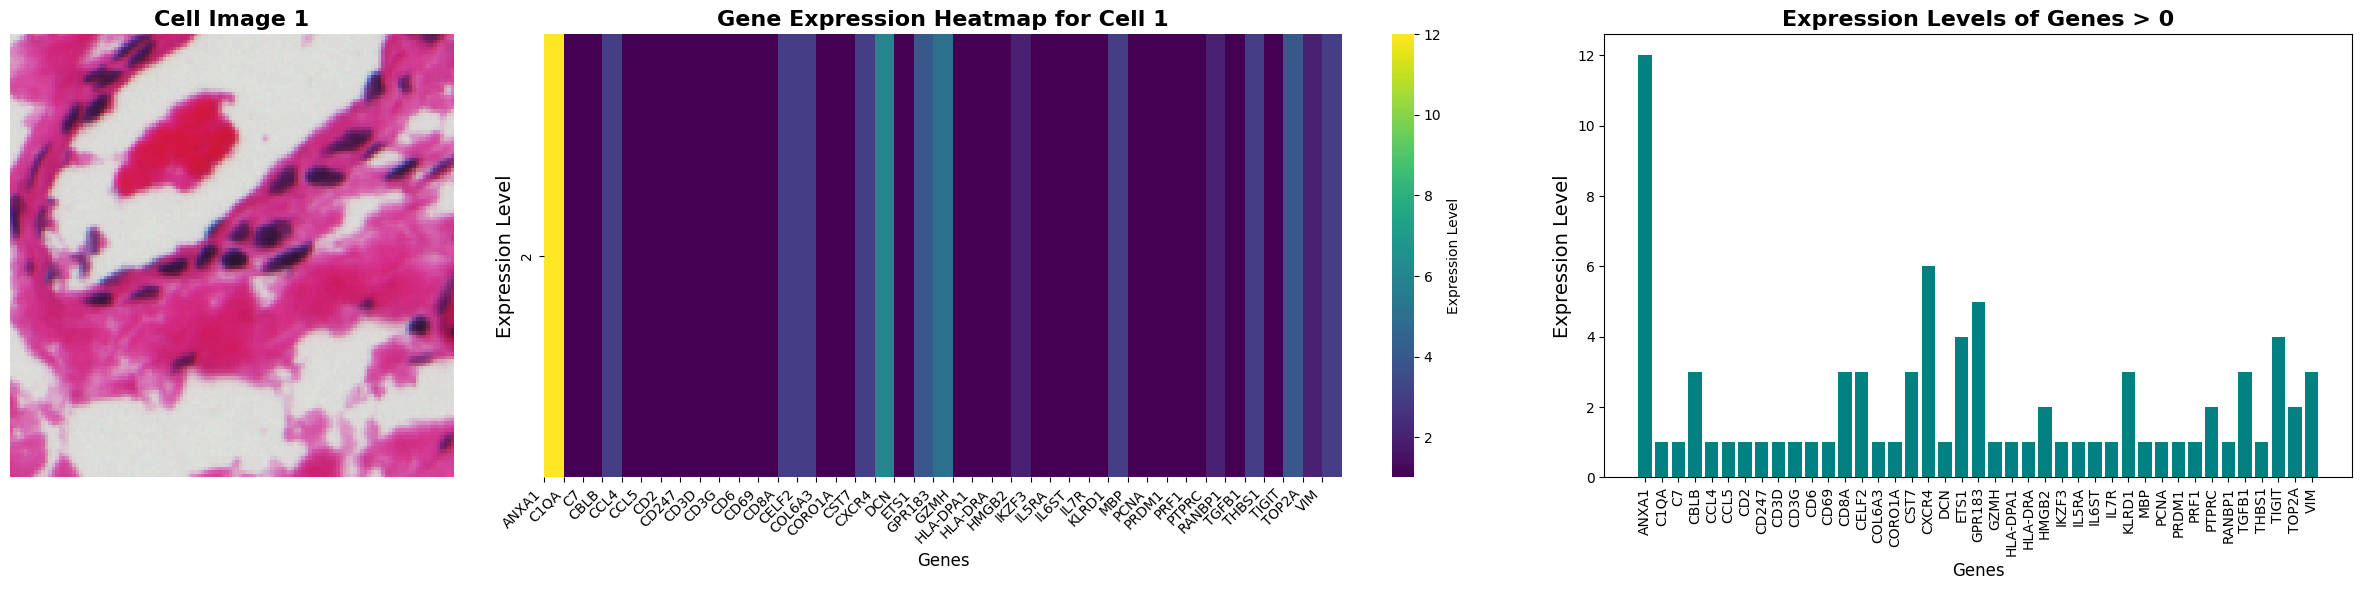

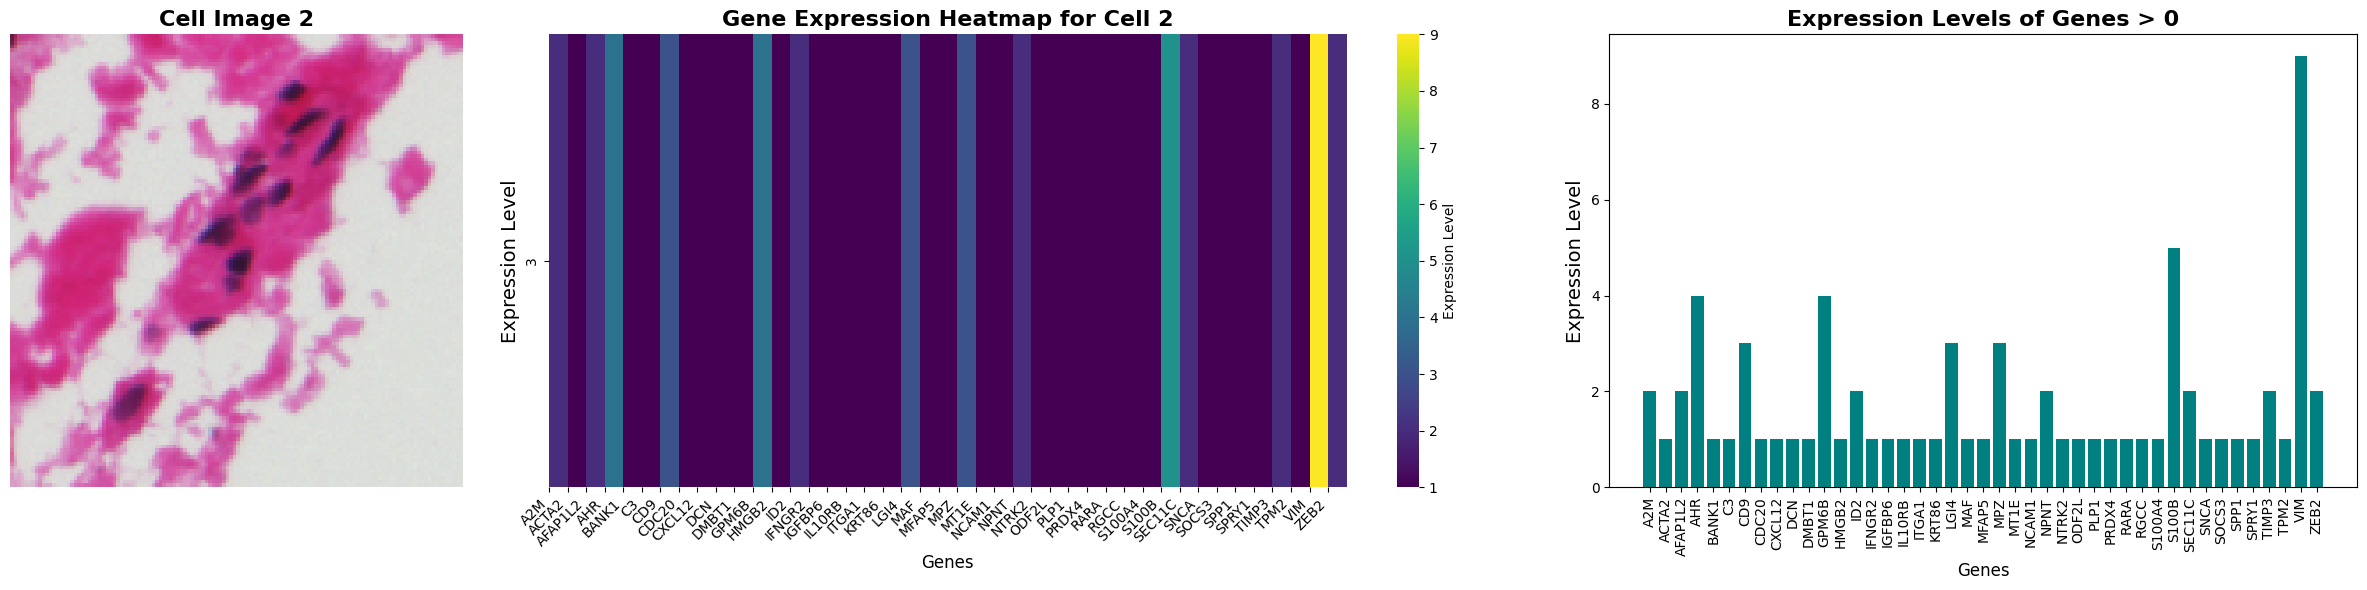

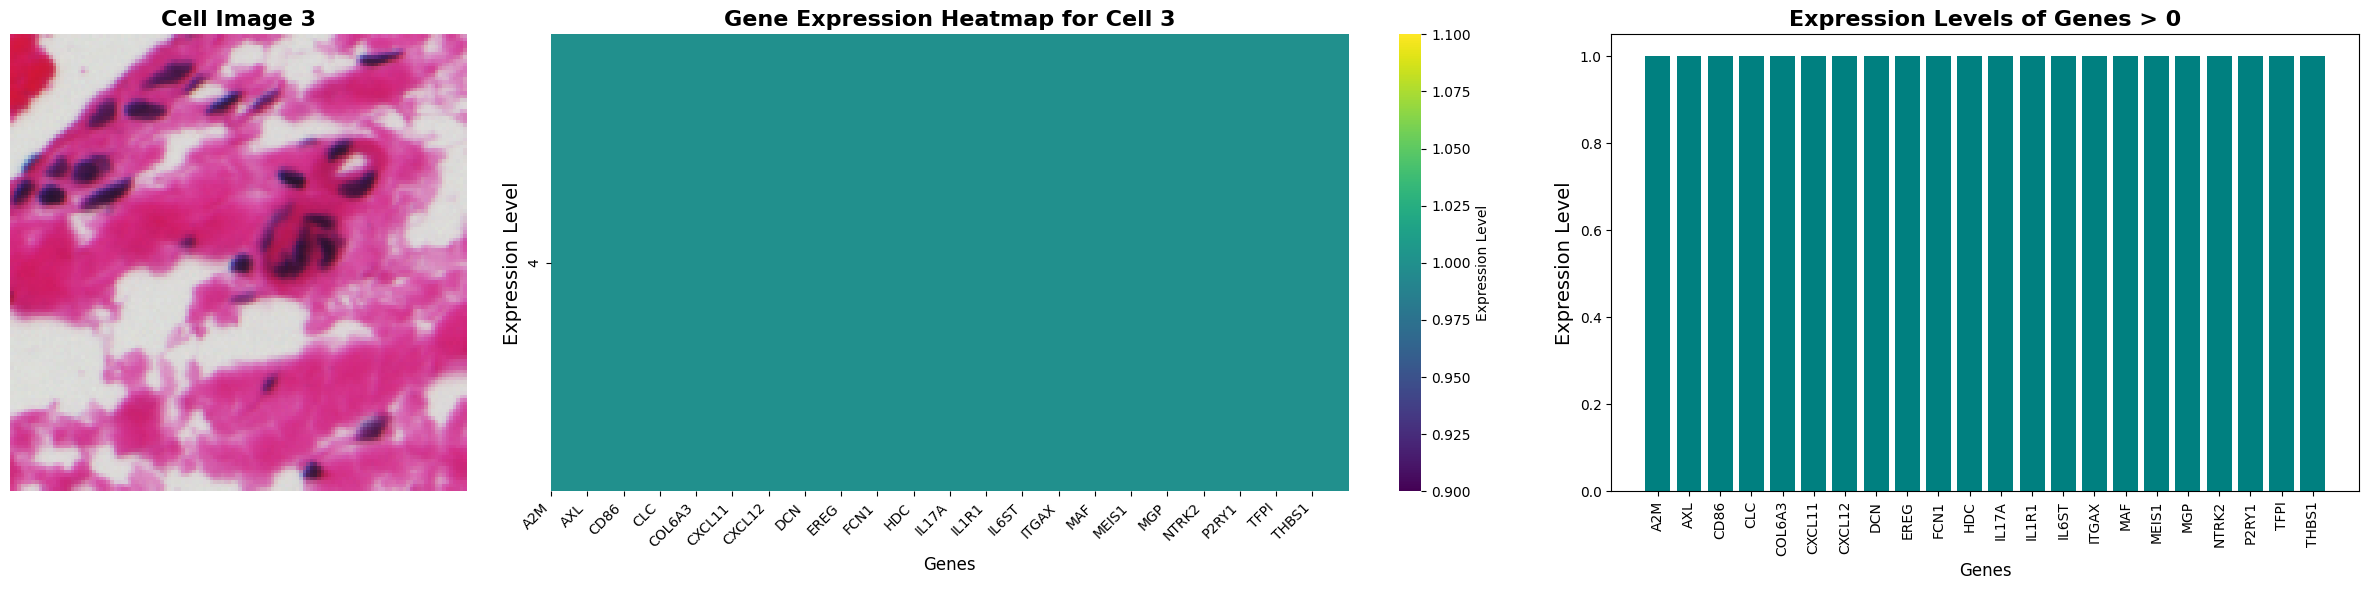

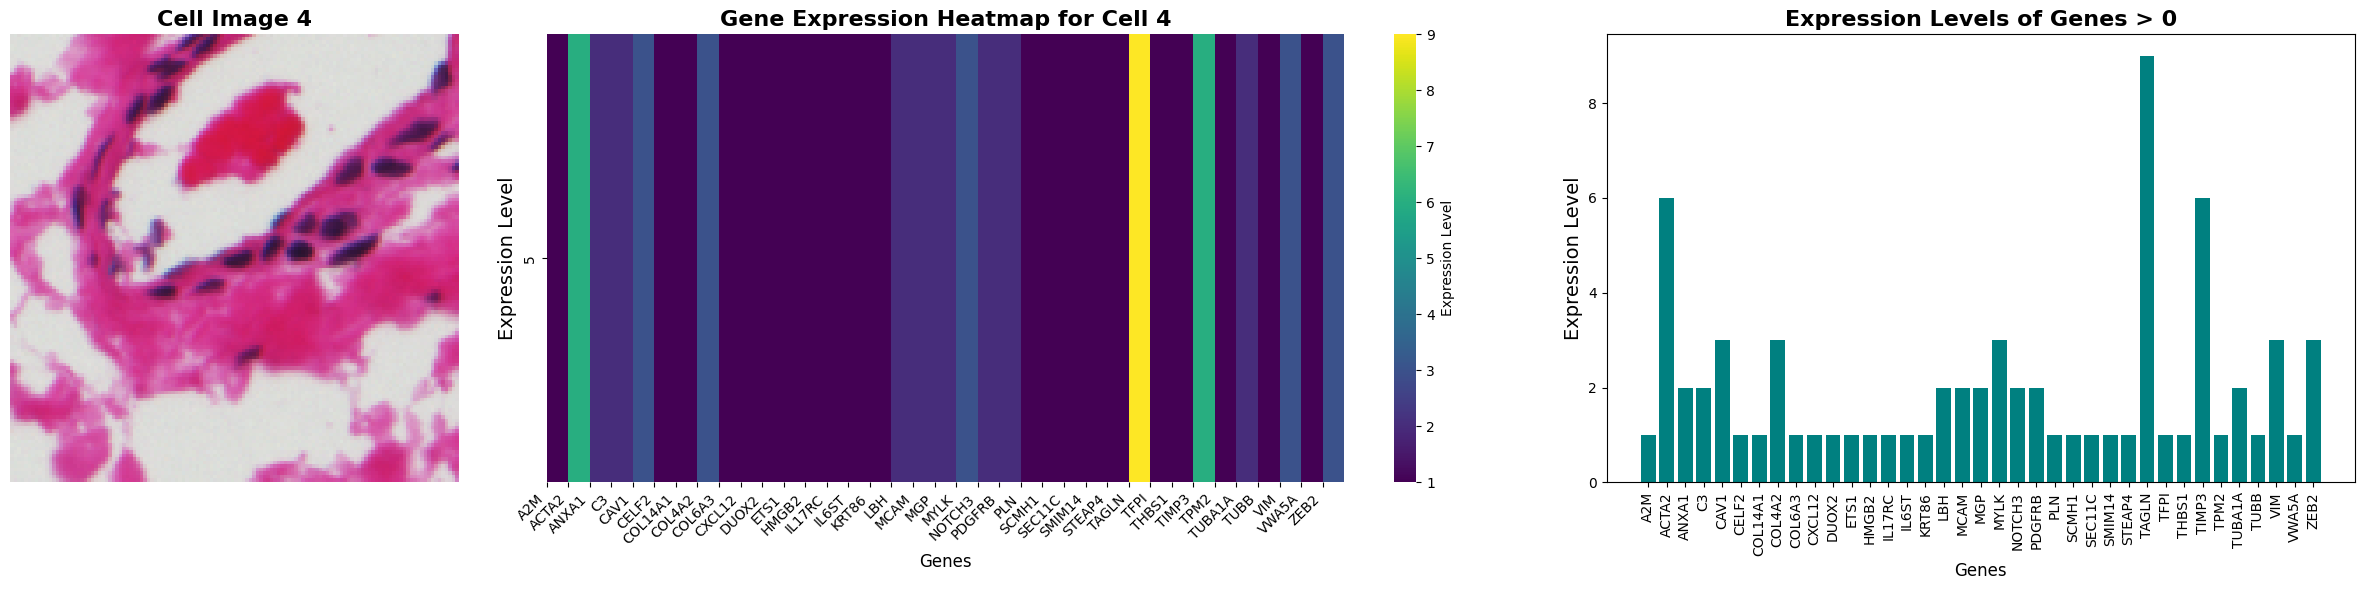

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Loop over the first four cells
for cell_id in range(5):
    # Create a figure with three subplots (image, heatmap, and bar chart)
    fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 2, 1.5]}, figsize=(24, 6))

    # First plot: Image of the cell on the left
    ax[0].imshow(crop_list[cell_id].transpose((1, 2, 0)))
    ax[0].set_title(f'Cell Image {cell_id}', fontsize=16, fontweight='bold')
    ax[0].axis('off')  # Hide axes for image clarity

    # Filter the gene expression data to include only genes with expression > 0
    gene_expression_data = y.iloc[cell_id]
    filtered_data = gene_expression_data[gene_expression_data > 0]
    heatmap_data = pd.DataFrame(filtered_data).transpose()

    # Second plot: Gene Expression Heatmap with filtered genes
    sns.heatmap(
        heatmap_data,
        annot=False,
        cmap='viridis',  # Color map for expression levels
        fmt=".2f",
        ax=ax[1],
        cbar_kws={'label': 'Expression Level'}  # Color bar with label
    )

    # Titles and labels with enhanced readability for heatmap
    ax[1].set_title(f'Gene Expression Heatmap for Cell {cell_id}', fontsize=16, fontweight='bold')
    ax[1].set_xlabel('Genes', fontsize=12)
    ax[1].set_ylabel('Expression Level', fontsize=14)
    ax[1].set_xticks(range(len(filtered_data.index)))
    ax[1].set_xticklabels(filtered_data.index, rotation=45, ha='right', fontsize=10)

    # Third plot: Bar Chart for gene expression levels
    ax[2].bar(filtered_data.index, filtered_data.values, color='teal')
    ax[2].set_title("Expression Levels of Genes > 0", fontsize=16, fontweight='bold')
    ax[2].set_xlabel("Genes", fontsize=12)
    ax[2].set_ylabel("Expression Level", fontsize=14)
    ax[2].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

In [ ]:
def log1p_normalization(arr):
    # max_vals = arr.max(axis=1, keepdims=True)
    return np.log1p((arr/np.sum(arr, axis=1)) * 100)

def scoring(model_output: pd.DataFrame, ground_truth: pd.DataFrame):
    mse = np.sum((np.square(model_output - ground_truth)).mean(axis=1))

    return mse

#TEST

In [47]:
import scprep as scp
a=scp.normalize.library_size_normalize([[1,2,3],[5,6,7]])
a

array([[1666.66666667, 3333.33333333, 5000.        ],
       [2777.77777778, 3333.33333333, 3888.88888889]])

In [3]:
import os
e='E:/projects/Gene_expression'
cnt_dir = f'{e}/data/her2st/data/ST-cnts'
img_dir = f'{e}/data/her2st/data/ST-imgs'
pos_dir = f'{e}/data/her2st/data/ST-spotfiles'
lbl_dir = f'{e}/data/her2st/data/ST-pat/lbl'
def get_cnt( name):
        path = cnt_dir + '/' + name + '.tsv'
        df = pd.read_csv(path, sep='\t', index_col=0)
        return df

def get_pos(name):
    path = pos_dir + '/' + name + '_selection.tsv'
    df = pd.read_csv(path, sep='\t')
    x = df['x'].values
    y = df['y'].values
    x = np.around(x).astype(int)
    y = np.around(y).astype(int)
    id = []
    for i in range(len(x)):
        id.append(str(x[i]) + 'x' + str(y[i]))
    df['id'] = id
    return df
def get_meta( name, gene_list=None):
        cnt = get_cnt(name)
        pos = get_pos(name)
        meta = cnt.join((pos.set_index('id')))
        return meta
e='E:/projects/Gene_expression'

names = os.listdir(cnt_dir)
names.sort()
names = [i[:2] for i in names][:2]
meta_dict = {i: get_meta(i) for i in names}
gene_list = list(np.load(f'{e}/data/her_hvg_cut_1000.npy', allow_pickle=True))

In [74]:
center_dict = {i: np.floor(m[['pixel_x', 'pixel_y']].values).astype(int) for i, m in
                            meta_dict.items()}
loc_dict = {i: m[['x', 'y']].values for i, m in meta_dict.items()}

In [84]:
c_sort=center_dict['A1']
c_sort.sort()
len(c_sort),len(loc_dict['A1'])


346

In [5]:
meta_dict.values()

dict_values([       FO538757.1  SAMD11  NOC2L  KLHL17  PLEKHN1  PERM1  HES4  ISG15  AGRN  \
10x13           0       6      1       0        0      0     2      0     0   
10x14           0       6      3       1        0      0     3      0     1   
10x15           1       1      0       0        0      0     6      1     2   
10x16           0       6      1       0        0      0     3      0     0   
10x17           0       1      2       0        0      0     4      0     1   
...           ...     ...    ...     ...      ...    ...   ...    ...   ...   
9x23            1       1      0       0        0      0     3      0     0   
9x24            0       1      5       1        0      0     1      1     0   
9x25            0       3      1       0        0      0     8      0     1   
9x26            0       2      2       0        0      0     4      0     0   
9x27            0       2      1       0        0      0     0      0     0   

       RNF223  ...  UTY  KDM5D  EIF1AY

In [7]:
lengths = [len(i) for i in meta_dict.values()]
lengths,np.cumsum(lengths)

([346, 325], array([346, 671]))

In [45]:
x_count = pd.DataFrame(sdata['anucleus'].layers['counts'], columns=gene_name_list) # raw count data
x_count


,A2M,ACP5,ACTA2,ADAMTSL3,AFAP1L2,AHR,ALDH1B1,ANO1,ANXA1,AQP1,...,VCAN,VIL1,VIM,VPREB3,VWA5A,WFDC2,XBP1,XCL2,XCR1,ZEB2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,2,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202529,1,0,0,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,0,0,0
202530,4,0,2,0,0,0,0,1,1,0,...,0,0,6,0,0,0,0,0,0,1
202531,0,0,0,0,0,0,0,0,5,0,...,0,0,1,0,0,0,0,0,0,0
202532,0,0,0,0,0,0,0,2,0,0,...,0,0,1,0,0,0,0,0,0,0


In [58]:
exp_dict = {
                i: sc.pp.scale(scp.transform.log(scp.normalize.library_size_normalize(m[gene_list].values))) for
                i, m in meta_dict.items()}

In [80]:
x_count['A2M']

0         0
1         0
2         0
3         0
4         1
         ..
202529    1
202530    4
202531    0
202532    0
202533    1
Name: A2M, Length: 202534, dtype: int64

In [106]:
x_norm.values[202532].sum()
# x_norm['A2M'].values.sum()

31.184797

In [89]:
test_log=scp.transform.log(scp.normalize.library_size_normalize(x_count[gene_name_list].values))

In [ ]:
list(gene_name_list)
# gene_list
exp_dict
# list_test= list( list(gene_name_list))
# list_test.index('ANXA1')
# x_count.items()

In [4]:
from skimage.measure import regionprops
from tqdm import tqdm
import tifffile
regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

In [140]:
d={}
d['1']=3
d

{'1': 3}

In [ ]:
for i, m in meta_dict.items():
    print(len(m[['pixel_x', 'pixel_y']].values))
    break
for i, m in meta_dict.items():
    print(len(m[['x', 'y']].values))
    break

346


In [23]:

# regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())
center_list=[]
cell_id_list=[]
for props in tqdm(regions):
    cell_id= props.label
    centroid = props.centroid
    center_list.append([int(centroid[0]), int(centroid[1])])
    cell_id_list.append(int(cell_id))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234356/234356 [00:16<00:00, 14453.20it/s]


In [ ]:
for i in range (20):
    print(center_list[i],cell_id_list[i])

[16936, 14070] 1
[16935, 14152] 3
[16943, 14061] 4
[16939, 14111] 5
[16941, 14039] 6
[16949, 14043] 7
[16933, 14063] 8
[16930, 14629] 9
[16929, 14886] 10
[16936, 14081] 11
[16975, 13927] 14
[17009, 13783] 15
[16956, 13575] 16
[16947, 13527] 17
[16937, 13799] 18
[16958, 13581] 19
[16948, 13830] 20
[17016, 13780] 21
[16930, 13115] 22
[16960, 13734] 23


In [ ]:
ar_test=sdata['anucleus'].layers['counts']

In [ ]:
ar_sum=ar_test[0] + ar_test[1]
ar_sum[ar_sum!=0], len(ar_sum[ar_sum!=0])

(array([1, 1, 1, 4, 3, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 2, 3, 1, 3, 1, 1, 1,
        2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 1, 1, 1, 5, 2, 3, 1,
        1, 1, 1, 1, 1, 1, 1], dtype=int64),
 51,
 460)

In [ ]:
ar_test[0][ar_test[0]!=0], len(ar_test[0][ar_test[0]!=0]),ar_test[1][ar_test[1]!=0], len(ar_test[1][ar_test[1]!=0])

(array([1, 3, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        5, 1, 1, 1, 1], dtype=int64),
 27,
 array([1, 1, 4, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 2, 2, 1,
        1, 1, 1, 1], dtype=int64),
 26)

In [ ]:
c_sort
len(center_list)

234356

In [ ]:
canvas_size = 10000
canvas = np.zeros((canvas_size, canvas_size))

# Mark each square centered at the coordinates
square_size = 128
half_square = square_size // 2

for x, y in c_sort:
    # Calculate the bounding box of the square
    x_start = max(x - half_square, 0)
    x_end = min(x + half_square, canvas_size)
    y_start = max(y - half_square, 0)
    y_end = min(y + half_square, canvas_size)
    
    # Set the square's region to a fixed intensity value
    canvas[y_start:y_start + 1, x_start:x_end] = 0.5  # Top edge
    canvas[y_end - 1:y_end, x_start:x_end] = 0.5      # Bottom edge
    canvas[y_start:y_end, x_start:x_start + 1] = 0.5  # Left edge
    canvas[y_start:y_end, x_end - 1:x_end] = 0.5      # Right edge
    
    # Mark vertices
    vertices = [(y_start, x_start), (y_start, x_end - 1),
                (y_end - 1, x_start), (y_end - 1, x_end - 1)]
    for vy, vx in c_sort:
        canvas[vy, vx] = 0.5


# Plotting the result
plt.figure(figsize=(21, 21))
plt.imshow(canvas, cmap='gray')
plt.scatter(*zip(*c_sort), color='red', marker='o',s=0.1)  # Overlay the points in red for contrast
plt.title('Single Channel Plot with Centered Squares')
plt.axis('off')
plt.show()

In [95]:
validation_id_list=list(sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'validation' ]['cell_id'])
test_id_list=list(sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'test' ]['cell_id'])


In [96]:
vt_center_list=[]
vt_cell_id_list=[]
vt_center_list=[]
t_cell_id_list=[]
t_center_list=[]
t_cell_id_list=[]
for props in tqdm(regions):
    cell_id= props.label
    centroid = props.centroid
    if cell_id in validation_id_list or cell_id in test_id_list:
        vt_center_list.append([int(centroid[0]), int(centroid[1])])
        vt_cell_id_list.append(int(cell_id))
    else:
        t_center_list.append([int(centroid[0]), int(centroid[1])])
        t_cell_id_list.append(int(cell_id))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234356/234356 [01:51<00:00, 2093.27it/s]


In [101]:
canvas_size = 20000
canvas = np.zeros((canvas_size, canvas_size))

# Mark each square centered at the coordinates
square_size = 64
half_square = square_size // 2

for x, y in vt_center_list:
    # Calculate the bounding box of the square
    x_start = max(x - half_square, 0)
    x_end = min(x + half_square, canvas_size)
    y_start = max(y - half_square, 0)
    y_end = min(y + half_square, canvas_size)
    
    # Set the square's region to a fixed intensity value
    canvas[y_start:y_start + 1, x_start:x_end] = 0.5  # Top edge
    canvas[y_end - 1:y_end, x_start:x_end] = 0.5      # Bottom edge
    canvas[y_start:y_end, x_start:x_start + 1] = 0.5  # Left edge
    canvas[y_start:y_end, x_end - 1:x_end] = 0.5      # Right edge
    
    # Mark vertices
    vertices = [(y_start, x_start), (y_start, x_end - 1),
                (y_end - 1, x_start), (y_end - 1, x_end - 1)]
    for vy, vx in c_sort:
        canvas[vy, vx] = 0.5


# Plotting the result
plt.figure(figsize=(200, 200))
plt.imshow(canvas, cmap='gray')
plt.scatter(*zip(*vt_center_list), color='red', marker='o',s=0.40)  # Overlay the points in red for contrast
plt.title('Single Channel Plot with Centered Squares')
plt.axis('off')
plt.show()

KeyboardInterrupt: 

In [ ]:
canvas_size = 20000
canvas = np.zeros((canvas_size, canvas_size))

# Mark each square centered at the coordinates
square_size = 64
half_square = square_size // 2

for x, y in t_center_list:
    # Calculate the bounding box of the square
    x_start = max(x - half_square, 0)
    x_end = min(x + half_square, canvas_size)
    y_start = max(y - half_square, 0)
    y_end = min(y + half_square, canvas_size)
    
    # Set the square's region to a fixed intensity value
    canvas[y_start:y_start + 1, x_start:x_end] = 0.5  # Top edge
    canvas[y_end - 1:y_end, x_start:x_end] = 0.5      # Bottom edge
    canvas[y_start:y_end, x_start:x_start + 1] = 0.5  # Left edge
    canvas[y_start:y_end, x_end - 1:x_end] = 0.5      # Right edge
    
    # Mark vertices
    vertices = [(y_start, x_start), (y_start, x_end - 1),
                (y_end - 1, x_start), (y_end - 1, x_end - 1)]
    for vy, vx in c_sort:
        canvas[vy, vx] = 0.5


# Plotting the result
plt.figure(figsize=(190, 190))
plt.imshow(canvas, cmap='gray')
plt.scatter(*zip(*t_center_list), color='red', marker='o',s=0.30)  # Overlay the points in red for contrast
plt.title('Single Channel Plot with Centered Squares')
plt.axis('off')
plt.show()
del canvas

KeyboardInterrupt: 

In [ ]:
canvas_size = 20000
canvas = np.zeros((canvas_size, canvas_size))

# Mark each square centered at the coordinates
square_size = 128
half_square = square_size // 2

for x, y in center_list:
    # Calculate the bounding box of the square
    x_start = max(x - half_square, 0)
    x_end = min(x + half_square, canvas_size)
    y_start = max(y - half_square, 0)
    y_end = min(y + half_square, canvas_size)
    
    # Set the square's region to a fixed intensity value
    canvas[y_start:y_start + 1, x_start:x_end] = 0.5  # Top edge
    canvas[y_end - 1:y_end, x_start:x_end] = 0.5      # Bottom edge
    canvas[y_start:y_end, x_start:x_start + 1] = 0.5  # Left edge
    canvas[y_start:y_end, x_end - 1:x_end] = 0.5      # Right edge
    
    # Mark vertices
    vertices = [(y_start, x_start), (y_start, x_end - 1),
                (y_end - 1, x_start), (y_end - 1, x_end - 1)]
    for vy, vx in c_sort:
        canvas[vy, vx] = 0.5


# Plotting the result
plt.figure(figsize=(20, 20))
plt.imshow(canvas, cmap='gray')
plt.scatter(*zip(*center_list), color='red', marker='o',s=0.10)  # Overlay the points in red for contrast
plt.title('Single Channel Plot with Centered Squares')
plt.axis('off')
plt.show()

In [8]:
len(sdata['anucleus'].layers['counts'])

80037